In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csr_matrix
import os

In [5]:
train = pd.read_csv(os.path.join(os.getcwd(),'Datasets/UNSW_NB15_testing-set.csv'))
test = pd.read_csv(os.path.join(os.getcwd(),'Datasets/UNSW_NB15_training-set.csv'))

In [7]:
pd.set_option('display.max_columns', None)

In [9]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [11]:
train['service'] = train['service'].apply(lambda x:'None' if x == '-' else x)

In [13]:
# Dropping columns which are not useful for the classification
# attack_cat is for multiclass classification
train.drop(['attack_cat'], axis=1, inplace=True)

In [15]:
train.duplicated().sum()

0

In [17]:
train['network_bytes'] = train['sbytes'] + train['dbytes']

In [19]:
train_coeff_df = train.copy()

In [21]:
train_coeff_df['proto'] = train_coeff_df['proto'].astype('category').cat.codes
train_coeff_df['service'] = train_coeff_df['service'].astype('category').cat.codes
train_coeff_df['state'] = train_coeff_df['state'].astype('category').cat.codes

In [23]:
train_coeff_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,network_bytes
0,1,0.000011,117,0,4,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,496
1,2,0.000008,117,0,4,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,1762
2,3,0.000005,117,0,4,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,0,1068
3,4,0.000006,117,0,4,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,900
4,5,0.000010,117,0,4,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,2126


In [25]:
train_coeff = train_coeff_df.corr()

In [26]:
upper = train_coeff.where(np.triu(np.ones(train_coeff.shape),k=1).astype(bool))

<Axes: >

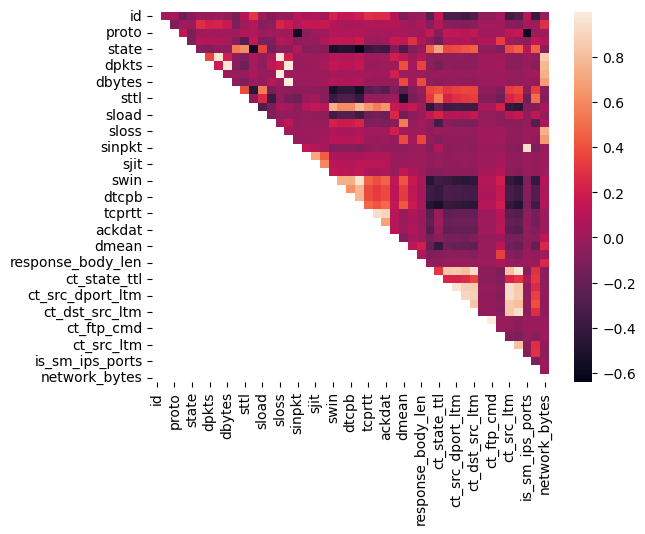

In [29]:
sns.heatmap(upper)

In [30]:
upper.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label', 'network_bytes'],
      dtype='object')

In [33]:
drop = []
for column in upper.columns:
    if any(upper[column] > 0.95):
        drop.append(column)

drop = [columns for columns in upper.columns if any(upper[columns] > 0.95)]

In [35]:
drop

['sbytes',
 'dbytes',
 'sloss',
 'dloss',
 'dwin',
 'ct_src_dport_ltm',
 'ct_ftp_cmd',
 'ct_srv_dst']

In [37]:
train.drop(drop, axis=1, inplace=True)

In [39]:
train.shape

(82332, 37)

In [41]:
saved_dict = {}
saved_dict['cat_columns'] = ['service','proto','state']
saved_dict['numerical_columns'] = list(set(train.columns) - set(['service','proto','state']))
saved_dict['Dropped_col'] = drop + ['attack_cat']

In [43]:
def multi_corr(col1,col2='label',df=train):
    corr = df[[col1,col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])
    print(f'--------------{col1}--------------\n correaltion = {corr} \n correlation of log = {log_corr}')

In [45]:
for column in list(set(train.columns) - set(saved_dict['cat_columns'])):
    multi_corr(column)

--------------dpkts--------------
 correaltion = -0.06151507696956742 
 correlation of log = -0.4118221181653369
--------------dur--------------
 correaltion = -0.0011452513082882902 
 correlation of log = -0.08995892262514889
--------------dload--------------
 correaltion = -0.2805342778137039 
 correlation of log = -0.5333143385538893
--------------dtcpb--------------
 correaltion = -0.2828602892308249 
 correlation of log = -0.36837031906296697
--------------ct_flw_http_mthd--------------
 correaltion = -0.07502845308187292 
 correlation of log = -0.07613568596880554
--------------spkts--------------
 correaltion = -0.027730785071289878 
 correlation of log = -0.33522660510007196
--------------network_bytes--------------
 correaltion = -0.006085381759158258 
 correlation of log = -0.3485126897526355
--------------dmean--------------
 correaltion = -0.21154369720710842 
 correlation of log = -0.4785274798934717
--------------sjit--------------
 correaltion = -0.02739687891268457 
 co

In [47]:
log_transform_cols = [
    'dmean', 'spkts', 'dpkts', 'network_bytes', 'sjit', 'djit',
    'stcpb', 'sload', 'dttl', 'dload', 'rate'
]
saved_dict['log_transformed'] = log_transform_cols

In [49]:
for column in log_transform_cols:
    train[column+'_log1p'] = train[column].apply(np.log1p)
    train.drop(columns = column, inplace = True)

**SCALING**

In [52]:
x_train = train.drop(columns=['label'],axis = 1).copy()
y_train = train['label']

In [54]:
xtrain,xval,ytrain,yval = train_test_split(x_train,y_train,test_size = 0.25,random_state = 42, stratify = y_train)

In [56]:
scaler_dict = {}

In [58]:
for column in list(set(x_train.columns) - set(saved_dict['cat_columns'])):
    scaler = StandardScaler()
    scaler.fit(x_train[[column]])
    x_train[column] = scaler.transform(x_train[[column]])
    scaler_dict[column] = scaler

In [60]:
saved_dict['scalers'] = scaler_dict

In [62]:
x_train.shape

(82332, 36)

In [64]:
x_train.head()

,id,dur,proto,service,state,sttl,sinpkt,dinpkt,swin,dtcpb,tcprtt,synack,ackdat,smean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,dmean_log1p,spkts_log1p,dpkts_log1p,network_bytes_log1p,sjit_log1p,djit_log1p,stcpb_log1p,sload_log1p,dttl_log1p,dload_log1p,rate_log1p
0,-1.732030,-0.213727,udp,None,INT,0.71944,-0.122179,-0.094169,-1.04792,-0.776754,-0.482025,-0.41291,-0.484073,0.520319,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.450186,-0.477994,-0.090857,-0.203143,-0.640033,-0.10607,-1.07769,-0.871168,-0.966844,-0.300554,-0.971012,-0.854499,-1.004694,1.192793,-1.076983,-1.045246,0.949246
1,-1.731988,-0.213728,udp,None,INT,0.71944,-0.122180,-0.094169,-1.04792,-0.776754,-0.482025,-0.41291,-0.484073,3.556716,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.450186,-0.477994,-0.090857,-0.203143,-0.640033,-0.10607,-1.07769,-0.871168,-0.966844,0.304247,-0.971012,-0.854499,-1.004694,1.541423,-1.076983,-1.045246,1.026407
2,-1.731946,-0.213729,udp,None,INT,0.71944,-0.122180,-0.094169,-1.04792,-0.776754,-0.482025,-0.41291,-0.484073,1.892214,-0.173648,-0.04191,-0.590304,0.591021,-0.563660,-0.450186,-0.390391,-0.090857,-0.203143,-0.640033,-0.10607,-1.07769,-0.871168,-0.966844,0.065278,-0.971012,-0.854499,-1.004694,1.534684,-1.076983,-1.045246,1.140289
3,-1.731904,-0.213729,udp,None,INT,0.71944,-0.122180,-0.094169,-1.04792,-0.776754,-0.482025,-0.41291,-0.484073,1.489280,-0.173648,-0.04191,-0.590304,0.591021,-0.444868,-0.450186,-0.390391,-0.090857,-0.203143,-0.522990,-0.10607,-1.07769,-0.871168,-0.966844,-0.016389,-0.971012,-0.854499,-1.004694,1.456990,-1.076983,-1.045246,1.096112
4,-1.731861,-0.213728,udp,None,INT,0.71944,-0.122179,-0.094169,-1.04792,-0.776754,-0.482025,-0.41291,-0.484073,4.429740,-0.173648,-0.04191,-0.590304,0.591021,-0.444868,-0.450186,-0.390391,-0.090857,-0.203143,-0.522990,-0.10607,-1.07769,-0.871168,-0.966844,0.393902,-0.971012,-0.854499,-1.004694,1.533653,-1.076983,-1.045246,0.972339


**ONE HOT ENCODING**

In [67]:
ohe_proto = OneHotEncoder()
ohe_service = OneHotEncoder()
ohe_state = OneHotEncoder()
ohe_proto = ohe_proto.fit(x_train['proto'].values.reshape(-1,1))
ohe_service = ohe_service.fit(x_train['service'].values.reshape(-1,1))
ohe_state = ohe_state.fit(x_train['state'].values.reshape(-1,1))

for column,ohe in zip(saved_dict['cat_columns'],[ohe_service,ohe_proto,ohe_state]):
    temp = ohe.transform(x_train[column].values.reshape(-1,1)).toarray()
    temp_df = pd.DataFrame(temp, columns = ohe.get_feature_names_out([column]))
    x_train = pd.concat([x_train.drop(column,axis = 1),temp_df],axis = 1)
    

In [68]:
saved_dict['encoders'] = {
    'proto': ohe_proto,
    'service': ohe_service,
    'state': ohe_state
}

In [71]:
with open(os.path.join(os.getcwd(),'UNSW_encoders/ohe_proto.pkl'),'wb') as to_write:
    pickle.dump(ohe_proto,to_write)
with open(os.path.join(os.getcwd(),'UNSW_encoders/ohe_service.pkl'),'wb') as to_write:
    pickle.dump(ohe_service,to_write)
with open(os.path.join(os.getcwd(),'UNSW_encoders/ohe_state.pkl'),'wb') as to_write:
    pickle.dump(ohe_state,to_write)

In [73]:
x_train.head()

,id,dur,sttl,sinpkt,dinpkt,swin,dtcpb,tcprtt,synack,ackdat,smean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,dmean_log1p,spkts_log1p,dpkts_log1p,network_bytes_log1p,sjit_log1p,djit_log1p,stcpb_log1p,sload_log1p,dttl_log1p,dload_log1p,rate_log1p,service_None,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,-1.732030,-0.213727,0.71944,-0.122179,-0.094169,-1.04792,-0.776754,-0.482025,-0.41291,-0.484073,0.520319,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.450186,-0.477994,-0.090857,-0.203143,-0.640033,-0.10607,-1.07769,-0.871168,-0.966844,-0.300554,-0.971012,-0.854499,-1.004694,1.192793,-1.076983,-1.045246,0.949246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.731988,-0.213728,0.71944,-0.122180,-0.094169,-1.04792,-0.776754,-0.482025,-0.41291,-0.484073,3.556716,-0.173648,-0.04191,-0.680474,0.591021,-0.563660,-0.450186,-0.477994,-0.090857,-0.203143,-0.640033,-0.10607,-1.07769,-0.871168,-0.966844,0.304247,-0.971012,-0.854499,-1.004694,1.541423,-1.076983,-1.045246,1.026407,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.731946,-0.213729,0

In [75]:
x_train.shape

(82332, 184)

**PIPELINE FUNCTION**

In [78]:
def clean_data(data,saved_dict = saved_dict):
    numerical_cols = data.select_dtypes(include = np.number).columns
    categorical_cols = data.select_dtypes(exclude = np.number).columns
    mode_dict = data.mode().iloc[0].to_dict()
    for column in data.columns:
        data[column] = data[column].fillna(mode_dict[column])
        data[column] = data[column].replace(' ',mode_dict[column])
        data[column] = data[column].apply(lambda x: 'None' if x == '-' else x)
    for column in list(set(categorical_cols) - set(saved_dict['cat_columns'])):
        data[column] = data[column].astype(float)
    return data

In [80]:
def log1_p(data,saved_dict = saved_dict):
    for column in saved_dict['log_transformed']:
        data[column+'_log1p'] = data[column].apply(np.log1p)
        data.drop(columns = column, inplace = True)
    return data

In [82]:
def standardise(data, saved_dict = saved_dict):
    scaler_dict = saved_dict['scalers']
    for column in scaler_dict:
        data[column] = scaler_dict[column].transform(data[[column]])  
    return data

In [84]:
def one_hot_encoder(data,saved_dict = saved_dict):
    encoders = saved_dict['encoders'] 
    for column in saved_dict['cat_columns']:
        temp = encoders[column].transform(data[column].values.reshape(-1,1)).toarray()
        temp_df = pd.DataFrame(temp, columns = encoders[column].get_feature_names_out([column]))
        temp_df.index = data.index
        data = pd.concat([data.drop(column,axis = 1),temp_df],axis = 1)
    return data
    

In [86]:
def data_conversion(data,saved_dict = saved_dict):
    data = data[-(data['proto'].isin(['rtp','icmp']))]
    x = data.drop(columns=['label'],axis = 1).copy()
    y = data['label']
    x['network_bytes'] = x['sbytes'] + x['dbytes']
    x.drop(columns = saved_dict['Dropped_col'], inplace = True)
    x = clean_data(x)
    x = log1_p(x)
    x = standardise(x)
    x = one_hot_encoder(x)
    return (x,y)
    

In [88]:
def data_conversion_multi(data,saved_dict = saved_dict):
    data = data[~(data['proto'].isin(['rtp','icmp']) | (data['attack_cat'] == 'Normal'))]
    x = data.drop(columns=['label'],axis = 1).copy()
    y = data['attack_cat']
    x['network_bytes'] = x['sbytes'] + x['dbytes']
    x.drop(columns = saved_dict['Dropped_col'], inplace = True)
    x = clean_data(x)
    x = log1_p(x)
    x = standardise(x)
    x = one_hot_encoder(x)
    return (x,y)

In [90]:
x_test,y_test = data_conversion(test)

**PICKLING**

In [99]:
def sparse_df(data):
    data_sparse = csr_matrix(data.values)
    cols = data.columns
    sparsedf = pd.DataFrame.sparse.from_spmatrix(data_sparse, columns = cols)
    return sparsedf

In [101]:
train_sparse = sparse_df(x_train)

In [103]:
test_sparse = sparse_df(x_test)

In [107]:
with open(os.path.join(os.getcwd(),'Intrusion_pickle/train.pkl'),'wb') as to_write:
    pickle.dump((train_sparse,y_train),to_write)
with open(os.path.join(os.getcwd(),'Intrusion_pickle/test.pkl'),'wb') as to_write:
    pickle.dump((test_sparse,y_test),to_write)
#with open(os.path.join(os.getcwd(),'Intrusion_pickle/train_multi.pkl'),'wb') as to_write:
#    pickle.dump((trainm_sparse,y_train_multi),to_write)
#with open(os.path.join(os.getcwd(),'Intrusion_pickle/test_multi.pkl'),'wb') as to_write:
#    pickle.dump((testm_sparse,y_test_multi),to_write)
#with open(os.path.join(os.getcwd(),'saved_dict.pkl'),'wb') as to_write:
#    pickle.dump(saved_dict,to_write)